# Automatic Differentiation for Scalars (Differentiable Programming)

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Knowledge](#Knowledge)
  * [Python Modules](#Python-Modules)
  * [Gradient Calculation by Backpropagation](#Gradient-Calculation-by-Backpropagation)
  * [Chain Rule](#Chain-Rule)
  * [Backpropagation](#Backpropagation)
* [Exercises](#Exercises)
  * [Compute the derivatives (pen & paper)](#Compute-the-derivatives-(pen-%26amp%3B-paper))
  * [Autodiff class Scalar](#Autodiff-class-%3Ccode%3EScalar%3C%2Fcode%3E)
* [Example: A computational graph using autodiff](#Example%3A-A-computational-graph-using-autodiff)
* [Example: Linear Regression using autodiff](#Example%3A-Linear-Regression-using-autodiff)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction
In this notebook you will implement a Scalar class that supports automatic differentiation.

The idea is to implement simple operators like $+$, $*$ and $^2$ and their derivatives. You can chain these operators together to create more complex functions. These functions apply the chain rule on the operators they comprise to compute the derivatives.

At the end of this notebook we'll apply your autodiff class in a linear regression example and compute the gradients of the weight and bias using autodiff. 

## Requirements

### Knowledge
This notebook deals with computational graphs, the chain rule and backpropagation. A recommended read on the topic is
* [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) by C. Olah [[OLA15]](#OLA15).

The Python implementation of the autodiff class is inspired by MXNet and discussed in-depth in the article
* [Deep Learning Programming Style](http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html) by Apacahe MXNet [[AP17]](#AP17).

### Python Modules

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

### Gradient Calculation by Backpropagation
Backpropagation is a method for efficient calculation of the gradient (and higher order derivatives).

If the (partial) derivative is defined for each operator, gradients of the computation graph can be computated automatically by backpropagation. The mathematical basis is the chain rule of calculus.

### Chain Rule
with $z = z(x(t), y(t))$

$$
 \frac{ d z}{d t} =  \frac{\partial z}{\partial x} \frac{d x}{d t} + \frac{\partial z}{\partial y} \frac{d y}{d t}
$$


#### Recursive Application of the Chain Rule
Chain rule for a function $c(b(w))$ ($c$ is a function of $b$ and $b$ is a function of $w$):

$$
\frac{\partial c(b(w))}{\partial w} = \frac{\partial c(b(w))}{\partial b} \frac{\partial b(w)}{\partial w} 
$$

#### Multivariable Chain Rule

$$
\frac{\partial}{\partial t} f(x(t), y(t)) =  \frac{\partial f}{\partial x} \frac{\partial x}{\partial t}+ \frac{\partial f}{\partial y}\frac{\partial y}{\partial t}
$$

If there are multiple paths to a parameter (here $t$), we must add the partial derivatives ("the gradients").  

#### Total derivative vs partial derivative
For $z = z(a, b)$
$$
 \frac{ d z}{d a} =  \frac{\partial z}{\partial a} \frac{d a}{d a} + \frac{\partial z}{\partial b} \frac{d b}{d a} = \frac{\partial z}{\partial a} + \frac{\partial z}{\partial b} \frac{d b}{d a} 
$$

if $b$ is independent of $a$, i.e. $\frac{d b}{d a} = 0$, we have:

$$
 \frac{ d z}{d a} =
  \frac{\partial z}{\partial a} + \frac{\partial z}{\partial b} \frac{d b}{d a} =  \frac{\partial z}{\partial a} 
$$

#### Sum and product rule

if $b$ is not a function of $u$:

$$
 \frac{ \partial (a b)}{\partial u} =  \frac{\partial a}{\partial u} b + a \frac{\partial b}{\partial u} = \frac{\partial a}{\partial u} b
$$

$$
 \frac{ \partial (a(u) + b)}{\partial u} =  \frac{\partial a}{\partial u}
$$


### Backpropagation

We have a computational graph to compute $c$ and two parameters in the graph $v$ and $w$. `o1,o2` and `o3` are arbitrary operators.

This is represented by the following computational graph:

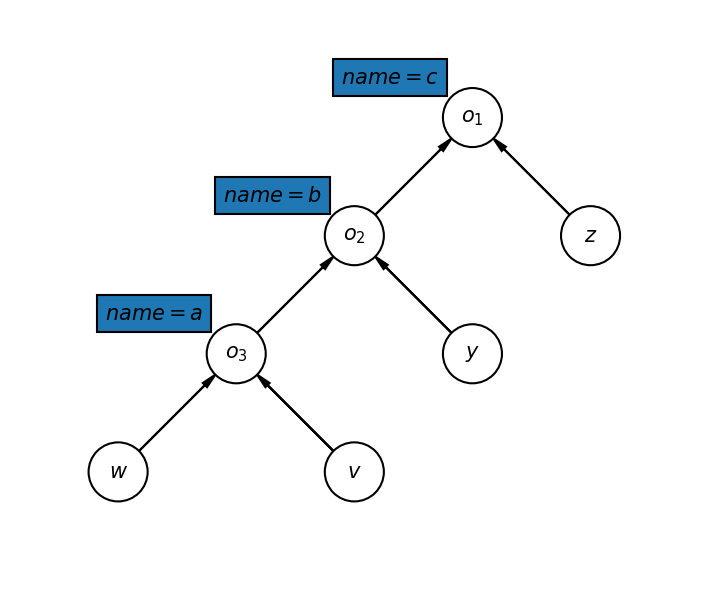

We want to compute the two partial derivatives $\frac{\partial c(b(a(w, v),y),z)}{\partial w}$ and $\frac{\partial c(b(a(w, v),y),z)}{\partial v}$.

Note that the application of the chain rule results in:
$$
\frac{\partial c(b(a(w, v),y),z)}{\partial w}  =
\frac{\partial c(b,z)}{\partial b}\frac{\partial b(a,y)}{\partial a} \frac{\partial a(w,v)}{\partial w}
$$


$$
\frac{\partial c(b(a(w, v),y),z)}{\partial v}  =
\frac{\partial c(b,z)}{\partial b}\frac{\partial b(a,y)}{\partial a} \frac{\partial a(w,v)}{\partial v}
$$

The first two factors of both expressions are the same. So we need to compute them only once. That's the key idea of backpropagation. We need to compute such factors only once and can backpropagate them through the graph.

#### Example for the given operator graph
Assume `o1` and `o3` are the multiplication operator ($*$) and `o2` is an add-operator ($+$).

Note that the application of the chain rule results in:

$$
\frac{\partial c}{\partial w}  =
\frac{\partial c(b,z)}{\partial b}\frac{\partial b}{\partial w} = 
\frac{\partial (z * b)}{\partial b}\frac{\partial b}{\partial w} 
= z \frac{\partial b}{\partial w}
$$


$$
\frac{\partial b}{\partial w} = \frac{\partial b(a,y)}{\partial w} = 
\frac{\partial b(a,y)}{\partial a} \frac{\partial a}{\partial w}=
\frac{\partial (a+y)}{\partial a}  \frac{\partial a}{\partial w}
= 1 \frac{\partial a}{\partial w}
$$


$$
\frac{\partial a}{\partial w} = \frac{\partial a(wv)}{\partial w} =  \frac{\partial a(wv)}{\partial w} = v
$$

so we have:

$$
\frac{\partial c}{\partial w}  = z * 1 * v = z * v
$$

For $\frac{\partial c}{\partial v}$ the first to factors of the chain rule ('$z$' and '1') are the same and we can reuse them.

$$
\frac{\partial c}{\partial v}  = z * 1 * \frac{\partial a(w,v)}{\partial w} = z * 1 * w = z * w
$$

## Exercises
### Compute the derivatives (pen & paper)
Consider the function
$$
E = (w_1 \cdot x_1 + w_2 \cdot x_2) \cdot (w_3 \cdot x_3) = h \cdot g
$$

with

$$
h = (w_1 \cdot x_1 + w_2 \cdot x_2) 
$$

$$
g = (w_3 \cdot x_3)
$$

Compute the partial derivative of $E$ with respect to each of the weights:

- $\frac{\partial E}{\partial w_1}$ 

- $\frac{\partial E}{\partial w_2}$

- $\frac{\partial E}{\partial w_3}$

Note:

In general for a Product-Node $g \cdot h$: $g$ flows back in the graph into the $h$-Branch for computing all derivatives $\frac{\partial E}{\partial w_i}$ in the $h$-Branch. So in a forward pass we would get the $g$ values. Then in the backward pass, we can propagate the $g$ values back through the $h$ branch to compute all derivatives on the $h$ branch $\frac{\partial E}{\partial w_i}$.

### Autodiff class `Scalar` 

Deep learning frameworks support automatic differentiation via backpropagation through the computational graph. 

To demonstrate how autodiff works we implement a simple autodiff python class `Scalar`. For each operator we have to implement additionally how the operator is differentiated. Therefore each operator
has a `grad`-function. 

Note: We have to add multiple path to the same variable as the multivariable chain rule tells us.

For the implementation we store the partial derivatives in a python `dict`ionary. 

We need a helper function `combine_dicts` for taking the _multivariate chain rule_ into account:

In [ ]:
import operator
def combine_dicts(a, b, op=operator.add):
    x = (list(a.items()) + list(b.items()) +
        [(k, op(a[k], b[k])) for k in set(b) & set(a)])
    return {x[i][0]: x[i][1] for i in range(0, len(x))}

In [ ]:
# Here you see how combine dicts work
a = {'a': 2, 'b':3, 'c':4}
b = {'a': 5, 'c':6, 'x':7}
combine_dicts(a, b)

In [ ]:
# and another example
A = {'a':-1.3, 'b':-4, 'c':3}
B = {'b':3, 'c':4, 'd':5}
combine_dicts(A,B)

In [ ]:
class Scalar(object) :
    """Simple Scalar object that supports autodiff."""
    
    def __init__(self, value, name=None):
        self.value = value
        if name:
            self.grad = lambda g : {name : g}
        else:
            self.grad = lambda g : {}
            
    def __add__(self, other):
        assert isinstance(other, Scalar)
        # forward pass: addition is simple:
        ret = Scalar(self.value + other.value)
        
        def grad(g):
            x = self.grad(g)
            x = combine_dicts(x, other.grad(g))
            return x
        ret.grad = grad
        
        return ret



Let's try and get a better understanding of what happens in the __add__ function by looking at an example of one operation. Node A and B are two scalar values. Node C is then constructed through the statement `C = A + B`, which is equivalent to both `C = A.__add__(B)` and `C = Scalar.__add__(A,B)`

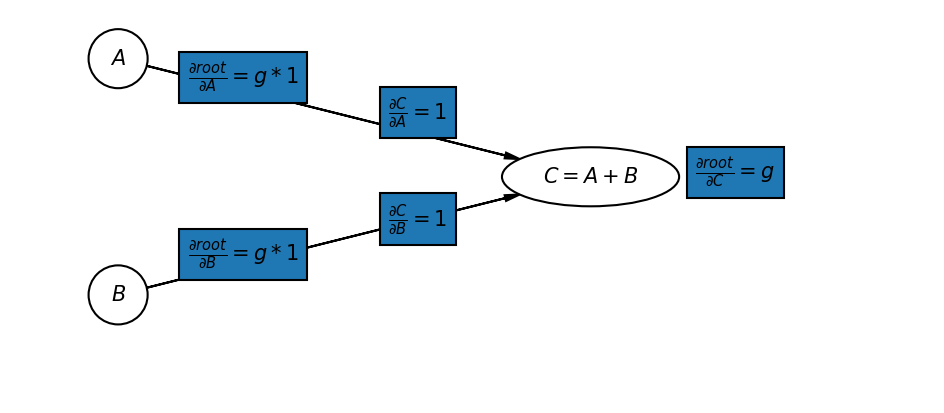

* In the `__add__` function, node `A` is stored in `self` and node B is stored in `other`. The node C which is being created is stored in `ret`.
* The derivatives of C with respect to its inputs are $\frac{\partial C}{\partial A} = 1$ and $\frac{\partial C}{\partial B} = 1$
* What about the argument `g`? g is the total backpropagated value so far. So it's the partial derivative of the output of the computational graph with respect to C, let's call it $\frac{\partial root}{\partial C}$ . The chain rule tells us to get the value of the entire computational graph with respect to `A` and `B`, we multiply this value with the current branch respectively. I.e.
   $$\frac{\partial root}{\partial A} = \frac{\partial root}{\partial C} * \frac{\partial C}{\partial A} = g * \frac{\partial C}{\partial A}$$
   
   $$\frac{\partial root}{\partial B} = \frac{\partial root}{\partial C} * \frac{\partial C}{\partial B} = g * \frac{\partial C}{\partial B}$$
* We pass the value $g * 1$ or just $g$ to the grad function of both `A` and `B`. We use the `combine_dicts` helper to produce the joined dictionary { 'A' : $\frac{\partial root}{\partial A}$ , 'B' : $\frac{\partial root}{\partial B}$ }

**Task:** Implement the multiplication and square ($^2$) operators.

In [ ]:
def __mul__(self, other):
    assert isinstance(other, Scalar)
    raise NotImplementedError()
    
    
    
def square(self):
    assert isinstance(other, Scalar)
    raise NotImplementedError()  

Scalar.__mul__ = __mul__
Scalar.square = square

### Example: A computational graph using autodiff
Consider this computational graph.

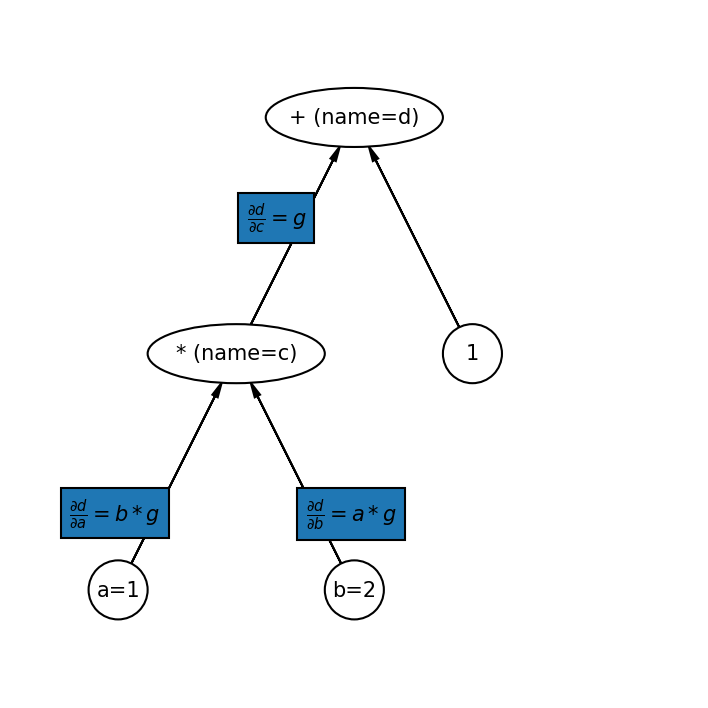
               
$g$ is the backpropagated "gradient value" - in general it is different at each position. It starts at the root of the tree with $g = 1$  (d root/d root = 1).

Example:
$$
d = (a * b) + 1
$$

$$
\frac{\partial d}{\partial a} = \frac{\partial (a*b+1)}{ \partial a} = b
$$

$$
\frac{\partial d}{\partial b} = \frac{\partial (a*b+1)}{ \partial b} = a
$$

In Python code using our autodiff `Scalar` class, we can construct the graph above and compute the derivatives like so:

In [ ]:
# Chain basic operations to construct a graph
a = Scalar(1., 'a')
b = Scalar(2., 'b')
c = b * a 
d = c + Scalar(1.)

# Copmute the derivatives of d with respect to a and b
derivatives = d.grad(1)
derivatives

**Verify your implementation:** You can run the following tests to test if your implementation is working as expected

In [ ]:
# test forward pass of multiplication
assert d.value == 3.

# test backward path of multipication
assert d.grad(1)['a']==2.0
assert d.grad(1)['b']==1.0

In [ ]:
a = Scalar(1., 'a')
b = Scalar(3., 'b')
c = b.square() * a 
d = (c + Scalar(1.)).square()

# test forward pass 
assert d.value == 100.

In [ ]:
# test backward pass 
assert d.grad(1)['a'] == 180
assert d.grad(1)['b'] == 120

### Example: Linear Regression using autodiff

In this example, we'll walk through an example of linear regression to show how the expressions can be implemented using the autodiff class.

In [ ]:
# generate some train data
x_min = -10.
x_max = 10.
m = 10

x = np.random.uniform(x_min, x_max, m)
a = 10.
c = 5.
y_noise_sigma = 3.
y = a + c * x + np.random.randn(len(x)) * y_noise_sigma

In [ ]:
plt.plot(x, y, "bo")
plt.xlabel("x")
plt.ylabel("y")

In the following snippet, we'll implement two fundamental equations pertaining linear regression using the `Scalar` class.

The output for an input $x$ with bias $b$ and weight $w$
> $h(x) = b + x * w$

The mean-squared-error cost over $m$ samples with ground truth $y$:
> $cost =\frac{1}{m}\sum_{i=1}^{m}{(h(x_i)-y_i)^2}$

In [ ]:
def linear_model_with_data(b_value, w_value, x_values, y_values):
    b = Scalar(b_value, name='b')
    w = Scalar(w_value, name='w')
    # MSE cost 
    cost = Scalar(0.)
    h = []
    
    # loop over training samples
    for x, y in zip(x_values, y_values):
        # The output of the model for x
        h_ = b + w * Scalar(x)
        # Compute and increment the cost
        diff = h_ + Scalar(-1.) * Scalar(y) 
        cost = cost + diff.square()
        h.append(h_)
    # take the mean (divide the cost by the number of samples)
    cost = cost * Scalar(1./nb_examples)
    return h, cost

In [ ]:
# Univariate Linear Regression

# train data
x_values = x
y_values = y

# start values
b_value=15.; w_value=2.

assert x_values.shape[0] == y_values.shape[0]
nb_examples = x_values.shape[0]

def get_linear_model(x_values, y_values):
    return lambda b_value, w_value: linear_model_with_data(
        b_value, w_value, x_values, y_values)
        

linear_model = get_linear_model(x_values, y_values)

h, cost = linear_model(b_value, w_value)
#print ([i.value for i in h] )
print (cost.value)

The key advantage of the scalar class is this: We can compute the derivatives of the cost function with a single call `cost.grad(1)`. The value $1$ is backpropagated through the graph and we obtain the derivatives of the cost w.r.t the weight $\frac{\partial{cost}}{\partial w}$ and w.r.t to the bias $\frac{\partial{cost}}{\partial b}$.
We can then use these derivatives in gradient descent to optimize the model.

In [ ]:
cost.grad(1)

In [ ]:
# Gradient Descent 

learning_rate = 0.01
n_iterations = 200

costs = np.ndarray([n_iterations])
for i in range(n_iterations):
    # compute the gradients of the cost w.r.t weight and bias
    deltas = cost.grad(1.)
    #print ("derivatives of cost:", cost.grad(1.))
    b_value = b_value - learning_rate * deltas['b']
    w_value = w_value - learning_rate * deltas['w']
    h, cost = linear_model(b_value, w_value)
    costs[i] = cost.value
    
#print ([i.value for i in h] ) 
print (b_value, w_value)
print (cost.value)

In [ ]:
plt.plot(range(n_iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")

In [ ]:
plt.plot(x,y, "bo")

xx = np.array((-10.,10))
yy = b_value + w_value * xx
plt.plot(xx, yy, 'r-')
plt.xlabel("x")
plt.ylabel("y")

## Literature

<table>
    <tr>
        <td>
            <a name="AP17"></a>[AP17]
        </td>
        <td>
            Apache MXNet, "Deep Learning Programming Style". [Online]. Available: <a href="http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html">http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html</a> [Accessed: 17-Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="OLA15"></a>[OLA15]
        </td>
        <td>
            C. Olah, "Calculus on Computational Graphs: Backpropagation" - Blog Article, August 31, 2015. [Online] Available: <a href='http://colah.github.io/posts/2015-08-Backprop/'>http://colah.github.io/posts/2015-08-Backprop/</a> [Accessed: 17- Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="BAY18"></a>[BAY18]
        </td>
        <td>
            Atilim Gunes Baydin, Barak A. Pearlmutter, Alexey Andreyevich Radul, Jeffrey Mark Siskind, "Automatic differentiation in machine learning: a survey", Journal of Machine Learning Research 18 (2018) 1-43  Apr. 2018. [Online]. Available: <a href="http://jmlr.org/papers/volume18/17-468/17-468.pdf">http://jmlr.org/papers/volume18/17-468/17-468.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="LM"></a>[LM]
        </td>
        <td>
            Erik Learned-Miller, 'Vector, Matrix, and Tensor Derivatives'. [Online]. Available: <a href="http://cs231n.stanford.edu/vecDerivs.pdf">http://cs231n.stanford.edu/vecDerivs.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="KAR"></a>[KAR]
        </td>
        <td>
            A.Karpathy, Lecture Notes CS 231 Convolutional Neural Networks for Visual Recognition: Backpropagation, Year Published. [Online]. Available: <a href="http://cs231n.github.io/optimization-2/)">http://cs231n.github.io/optimization-2/)</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    
    
    
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Automatic Differentiation for Scalars_ <br/>
by _[Christian Herta](https://www.htw-berlin.de/forschung/online-forschungskatalog/publikationen/person/?eid=2605)_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 _[Christian Herta](https://www.htw-berlin.de/forschung/online-forschungskatalog/publikationen/person/?eid=2605)_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.